<a href="https://colab.research.google.com/github/AbstractEyes/ABSItems/blob/main/BranchingResnetModel_LowAccuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.experimental.numpy as ops
# prepares tiny-imagenet for training.
!pip install datasets  # If not already installed
from datasets import load_dataset
import numpy as np
from PIL import Image
model = None

from google.colab import userdata


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Data Preparation

In [11]:
# Section 1: Download, Prepare, and Preprocess Dataset

import os
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm


def download_dataset(hf_repo, save_dir='datasets/tiny_imagenet'):
    """
    Downloads the dataset from the Hugging Face repository and saves it locally.

    Args:
        hf_repo (str): Hugging Face repository identifier (e.g., 'Maysee/tiny-imagenet').
        save_dir (str): Local directory to save the downloaded dataset.
    """
    print(f"Downloading dataset from Hugging Face repository: {hf_repo}")
    dataset = load_dataset(hf_repo, split='train', streaming=False)
    valid_dataset = load_dataset(hf_repo, split='valid', streaming=False)

    # Save training examples
    train_images = []
    train_labels = []
    print("Saving training examples locally...")
    for example in tqdm(dataset):
        img = example['image'].convert('RGB').resize((64, 64), Image.Resampling.LANCZOS)
        img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
        label = int(example['label'])
        train_images.append(img_array)
        train_labels.append(label)

    # Save validation examples
    valid_images = []
    valid_labels = []
    print("Saving validation examples locally...")
    for example in tqdm(valid_dataset):
        img = example['image'].convert('RGB').resize((64, 64), Image.Resampling.LANCZOS)
        img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
        label = int(example['label'])
        valid_images.append(img_array)
        valid_labels.append(label)

    # Convert lists to NumPy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    valid_images = np.array(valid_images)
    valid_labels = np.array(valid_labels)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save as NPZ files for backup (optional)
    #np.savez_compressed(os.path.join(save_dir, 'train.npz'), images=train_images, labels=train_labels)
    #np.savez_compressed(os.path.join(save_dir, 'valid.npz'), images=valid_images, labels=valid_labels)

    print(f"Dataset saved locally at '{save_dir}'.")
    return (train_images, train_labels), (valid_images, valid_labels)

def serialize_example(image, label):
    """
    Creates a tf.train.Example message ready to be written to a file.

    Args:
        image (np.array): Image data as a flattened array.
        label (int): Integer label.

    Returns:
        bytes: Serialized Example.
    """
    feature = {
        'image': tf.train.Feature(float_list=tf.train.FloatList(value=image.flatten())),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecord(images, labels, filename):
    """
    Writes preprocessed images and labels to a TFRecord file.

    Args:
        images (np.array): Array of preprocessed images.
        labels (np.array): Array of integer labels.
        filename (str): Path to the TFRecord file to be written.
    """
    with tf.io.TFRecordWriter(filename) as writer:
        for image, label in tqdm(zip(images, labels), total=len(images), desc=f"Writing {filename}"):
            serialized = serialize_example(image, label)
            writer.write(serialized)
    print(f"TFRecord file '{filename}' created successfully.")

def preprocess_data(size_constraints=(64, 64, 3), storage_shape=(64, 64, 3), save_dir='datasets/tiny_imagenet', save_to_hf_repo=None):
    """
    Preprocesses the dataset and saves it as TFRecord files locally.

    Args:
        size_constraints (tuple): Desired size of the images (height, width, channels).
        storage_shape (tuple): Shape to store the images.
        save_dir (str): Directory where the preprocessed data will be saved.
    """
    # Load and preprocess the dataset
    (train_images, train_labels), (valid_images, valid_labels) = download_dataset(
        hf_repo='Maysee/tiny-imagenet',
        save_dir=save_dir
    )

    # Define TFRecord file paths
    tfrecord_dir = os.path.join(save_dir, 'tfrecords')
    os.makedirs(tfrecord_dir, exist_ok=True)
    train_tfrecord = os.path.join(tfrecord_dir, 'train.tfrecord')
    valid_tfrecord = os.path.join(tfrecord_dir, 'valid.tfrecord')

    # Write TFRecord files
    write_tfrecord(train_images, train_labels, train_tfrecord)
    write_tfrecord(valid_images, valid_labels, valid_tfrecord)
    if save_to_hf_repo:
        upload_to_huggingface(repo_id=save_to_hf_repo, local_dir=save_dir)

    print("Preprocessing complete. TFRecord files are ready for use.")

from huggingface_hub import HfApi, HfFolder, create_repo, upload_folder
import os
from tqdm import tqdm

def upload_to_huggingface(repo_id, local_dir, token=None, repo_type='dataset'):
    """
    Uploads the preprocessed data to the Hugging Face Hub.

    Args:
        repo_id (str): Hugging Face repository identifier (e.g., 'username/tiny-imagenet').
        local_dir (str): Local directory where the preprocessed data is stored (e.g., 'datasets/tiny_imagenet').
        token (str, optional): Hugging Face authentication token. If not provided, it will be read from the 'HF_TOKEN' environment variable.
        repo_type (str, optional): Type of repository, e.g., 'dataset', 'model'. Default is 'dataset'.
    """
    # Import necessary functions
    from huggingface_hub import HfApi, HfFolder, create_repo, upload_folder

    # Authenticate
    if token is None:
        token = os.getenv('HF_TOKEN')
        if token is None:
            raise ValueError("Hugging Face token not provided. Set it via the 'token' parameter or 'HF_TOKEN' environment variable.")

    api = HfApi()

    # Check if the repository exists; if not, create it
    try:
        repo_info = api.repo_info(repo_id)
        print(f"Repository '{repo_id}' already exists on Hugging Face Hub.")
    except Exception as e:
        print(f"Creating repository '{repo_id}' on Hugging Face Hub.")
        create_repo(repo_id=repo_id, repo_type=repo_type, token=token, exist_ok=True)
        print(f"Repository '{repo_id}' created successfully.")

    # Define the path to the TFRecord files
    tfrecord_dir = os.path.join(local_dir, 'tfrecords')

    if not os.path.exists(tfrecord_dir):
        raise FileNotFoundError(f"TFRecord directory '{tfrecord_dir}' does not exist.")

    # Upload the folder
    print(f"Uploading TFRecord files from '{tfrecord_dir}' to repository '{repo_id}'. This may take a while...")

    upload_folder(
        folder_path=tfrecord_dir,
        repo_id=repo_id,
        repo_type=repo_type,
        token=token,
        path_in_repo='tfrecords',  # Destination folder in the repository
        commit_message="Upload preprocessed TFRecord files"
    )

    print(f"TFRecord files uploaded successfully to '{repo_id}'.")

In [16]:
# Execute preprocessing -> only execute preprocessing for the dataset if the dataset does not exist.
#if not os.path.exists("datasets/tiny_imagenet/tfrecords"):
#preprocess_data(save_to_hf_repo="AbstractPhil/tiny_imagenet_keras")
#preprocess_data()
from google.colab import userdata


upload_to_huggingface(repo_id="AbstractPhil/tiny_imagenet_keras", local_dir="datasets/tiny_imagenet", token=userdata.get('HF_TOKEN'))

Creating repository 'AbstractPhil/tiny_imagenet_keras' on Hugging Face Hub.
Repository 'AbstractPhil/tiny_imagenet_keras' created successfully.
Uploading TFRecord files from 'datasets/tiny_imagenet/tfrecords' to repository 'AbstractPhil/tiny_imagenet_keras'. This may take a while...


train.tfrecord:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

valid.tfrecord:   0%|          | 0.00/492M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

TFRecord files uploaded successfully to 'AbstractPhil/tiny_imagenet_keras'.


# Data Loading

In [2]:
!pip install huggingface_hub
import os
import tensorflow as tf
from huggingface_hub import hf_hub_download
from tqdm import tqdm

class HuggingFaceTFRecordLoader:
    def __init__(self, repo_id, token=None, local_dir='cached_tfrecords'):
        """
        Initializes the loader with the repository ID and authentication token.

        Args:
            repo_id (str): Hugging Face repository identifier (e.g., 'username/tiny-imagenet').
            token (str, optional): Hugging Face API token. If None, it will use the 'HF_TOKEN' environment variable.
            local_dir (str): Local directory to cache the downloaded TFRecord files.
        """
        self.repo_id = repo_id
        self.token = token or os.getenv('HF_TOKEN')
        self.local_dir = local_dir
        os.makedirs(self.local_dir, exist_ok=True)
        self.tfrecord_files = self._get_tfrecord_files()

    def _get_tfrecord_files(self):
        """
        Retrieves the list of TFRecord files in the 'tfrecords' folder of the repository.

        Returns:
            list: List of TFRecord file paths.
        """
        # List of expected TFRecord files
        expected_files = ['train.tfrecord', 'valid.tfrecord']
        existing_files = []

        for file_name in expected_files:
            try:
                # Attempt to download the file; this will raise an error if the file doesn't exist
                tfrecord_path = hf_hub_download(
                    repo_id=self.repo_id,
                    repo_type='dataset',
                    filename=f'tfrecords/{file_name}',
                    token=self.token,
                    local_dir=self.local_dir,
                    local_dir_use_symlinks=False
                )
                existing_files.append(tfrecord_path)
                print(f"Downloaded '{file_name}' successfully.")
           #except hf_hub_download.RepositoryNotFoundError:
           #    print(f"Repository '{self.repo_id}' not found.")
           #    continue
            except FileNotFoundError:
                print(f"TFRecord file '{file_name}' not found in repository '{self.repo_id}'.")
                continue
            except Exception as e:
                print(f"Error downloading '{file_name}': {e}")
                continue

        if not existing_files:
            raise FileNotFoundError(f"No TFRecord files found in the 'tfrecords' folder of '{self.repo_id}'.")

        return existing_files

    def _parse_example(self, example_proto):
        """
        Parses a single TFRecord example.

        Args:
            example_proto (tf.Tensor): Serialized example.

        Returns:
            tuple: (image, label)
        """
        # Define the feature description dictionary
        feature_description = {
            'image': tf.io.FixedLenFeature([64 * 64 * 3], tf.float32),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        # Parse the input tf.train.Example proto
        parsed_example = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.reshape(parsed_example['image'], [64, 64, 3])
        label = tf.cast(parsed_example['label'], tf.int32)
        return image, label

    def get_dataset(self, split='train', batch_size=32, shuffle=True, buffer_size=1000):
        """
        Creates a TensorFlow dataset from the TFRecord files.

        Args:
            split (str): Which split to load ('train' or 'valid').
            batch_size (int): Batch size.
            shuffle (bool): Whether to shuffle the dataset.
            buffer_size (int): Buffer size for shuffling.

        Returns:
            tf.data.Dataset: Prepared dataset.
        """
        if split == 'train':
            tfrecord_path = os.path.join(self.local_dir, 'tfrecords', 'train.tfrecord')
        elif split == 'valid':
            tfrecord_path = os.path.join(self.local_dir, 'tfrecords', 'valid.tfrecord')
        else:
            raise ValueError("Invalid split name. Choose 'train' or 'valid'.")

        if not os.path.exists(tfrecord_path):
            raise FileNotFoundError(f"TFRecord file for split '{split}' not found at '{tfrecord_path}'.")

        raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
        parsed_dataset = raw_dataset.map(self._parse_example, num_parallel_calls=tf.data.AUTOTUNE)

        if shuffle:
            parsed_dataset = parsed_dataset.shuffle(buffer_size=buffer_size)

        parsed_dataset = parsed_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return parsed_dataset

    def list_available_splits(self):
        """
        Lists available splits in the repository.

        Returns:
            list: List of available splits ('train', 'valid').
        """
        splits = []
        for file_path in self.tfrecord_files:
            if 'train.tfrecord' in file_path:
                splits.append('train')
            elif 'valid.tfrecord' in file_path:
                splits.append('valid')
        return splits


In [3]:
    # Define your Hugging Face repository ID
    hf_repo_id = 'AbstractPhil/tiny_imagenet_keras'  # <-- Replace with your actual Hugging Face repo ID

    # Initialize the loader
    loader = HuggingFaceTFRecordLoader(repo_id=hf_repo_id, token=userdata.get('HF_TOKEN'))

    # List available splits
    available_splits = loader.list_available_splits()
    print(f"Available splits: {available_splits}")

    # Get the training dataset
    train_dataset = loader.get_dataset(split='train', batch_size=32, shuffle=True, buffer_size=1000)

    # Get the validation dataset
    valid_dataset = loader.get_dataset(split='valid', batch_size=32, shuffle=False)

    # Example: Iterate over the training dataset
    for batch_images, batch_labels in train_dataset.take(1):
        print(f"Batch images shape: {batch_images.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        # Your training code here

    # Example: Iterate over the validation dataset
    for batch_images, batch_labels in valid_dataset.take(1):
        print(f"Validation batch images shape: {batch_images.shape}")
        print(f"Validation batch labels shape: {batch_labels.shape}")
        # Your evaluation code here

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:834: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Downloaded 'train.tfrecord' successfully.
Downloaded 'valid.tfrecord' successfully.
Available splits: ['train', 'valid']
Batch images shape: (32, 64, 64, 3)
Batch labels shape: (32,)
Validation batch images shape: (32, 64, 64, 3)
Validation batch labels shape: (32,)


# Model Handling

In [2]:
import struct
import math

def is_prime(n):
    """Check if a number is prime."""
    if n <= 1:
        return False
    if n <= 3:
        return True
    if n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    w = 2
    while i * i <= n:
        if n % i == 0:
            return False
        i += w
        w = 6 - w
    return True

def generate_primes(count):
    """Generate the first 'count' prime numbers."""
    primes = []
    num = 2
    while len(primes) < count:
        if is_prime(num):
            primes.append(num)
        num += 1
    return primes

def fast_inverse_sqrt(number):
    """
    Compute an approximation to the inverse square root of a number using
    the fast inverse square root algorithm.
    """
    threehalfs = 1.5

    x2 = number * 0.5
    y = number

    # Pack the float into 4 bytes, then unpack as integer
    packed_y = struct.pack('f', y)
    i = struct.unpack('I', packed_y)[0]

    # Magic number and bit manipulation
    magic = 0x5f3759df
    i = magic - (i >> 1)

    # Pack the integer back into bytes, then unpack as float
    packed_i = struct.pack('I', i)
    y = struct.unpack('f', packed_i)[0]

    # One iteration of Newton-Raphson method
    y = y * (threehalfs - (x2 * y * y))
    # Optional second iteration can be uncommented for higher accuracy
    # y = y * (threehalfs - (x2 * y * y))

    return y

def generate_roots(count):
    """
    Generate a list of inverse square root values for the first 'count' prime numbers.

    Parameters:
    - count (int): The number of prime numbers and inverse square roots to generate.

    Returns:
    - List[float]: A list containing the inverse square roots of the first 'count' prime numbers.
    """
    primes = generate_primes(count)
    roots = [fast_inverse_sqrt(float(p)) for p in primes]
    return roots

# Example Usage
if __name__ == "__main__":
    count = 35
    inverse_roots = generate_roots(count)
    primes = generate_primes(count)
    print(f"{'Prime':>10} | {'Fast Inv Sqrt':>15} | {'Actual Inv Sqrt':>15} | {'Error (%)':>10}")
    print("-" * 60)
    for p, fi, actual in zip(primes, inverse_roots, [1.0 / math.sqrt(p) for p in primes]):
        error = abs((fi - actual) / actual) * 100
        print(f"{p:10} | {fi:15.8f} | {actual:15.8f} | {error:10.6f}%")


     Prime |   Fast Inv Sqrt | Actual Inv Sqrt |  Error (%)
------------------------------------------------------------
         2 |      0.70693004 |      0.70710678 |   0.024995%
         3 |      0.57684684 |      0.57735027 |   0.087197%
         5 |      0.44714101 |      0.44721360 |   0.016231%
         7 |      0.37744416 |      0.37796447 |   0.137661%
        11 |      0.30103615 |      0.30151134 |   0.157603%
        13 |      0.27731250 |      0.27735010 |   0.013556%
        17 |      0.24238884 |      0.24253563 |   0.060519%
        19 |      0.22941458 |      0.22941573 |   0.000501%
        23 |      0.20827892 |      0.20851441 |   0.112937%
        29 |      0.18548521 |      0.18569534 |   0.113155%
        31 |      0.17951073 |      0.17960530 |   0.052657%
        37 |      0.16417872 |      0.16439899 |   0.133982%
        41 |      0.15590072 |      0.15617376 |   0.174832%
        43 |      0.15224285 |      0.15249857 |   0.167689%
        47 |      0.14570

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers

def residual_block(inputs, filters, stride=1, use_projection=False, name=None, kernel_regularizer=0.001):
    if name is None:
        raise ValueError("The 'name' parameter must be provided for the residual block.")

    shortcut = inputs
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(kernel_regularizer), name=f"{name}_conv1")(inputs)
    x = layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = layers.Activation('relu', name=f"{name}_relu1")(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(kernel_regularizer),
                      name=f"{name}_conv2")(x)
    x = layers.BatchNormalization(name=f"{name}_bn2")(x)

    if use_projection:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                                 kernel_initializer='he_normal',
                                 name=f"{name}_conv_shortcut")(inputs)
        shortcut = layers.BatchNormalization(name=f"{name}_bn_shortcut")(shortcut)

    x = layers.Add(name=f"{name}_add")([x, shortcut])
    x = layers.Activation('relu', name=f"{name}_relu2")(x)
    return x

def create_branch_with_global_pooling(inputs, filters, branch_id, stride, kernel_regularizer=0.001, pooling='avg'):
    if not isinstance(branch_id, int) or branch_id < 1:
        raise ValueError("branch_id must be a positive integer.")

    if pooling not in ['avg', 'max']:
        raise ValueError("Pooling type must be either 'avg' or 'max'.")

    name = f"branch_{branch_id}"
    x = residual_block(inputs, filters, stride=stride, use_projection=True, name=f"{name}_res1", kernel_regularizer=kernel_regularizer)
    x = layers.Dropout(0.5, name=f"{name}_dropout1")(x)
    x = residual_block(x, filters, stride=1, use_projection=False, name=f"{name}_res2", kernel_regularizer=kernel_regularizer)
    x = layers.Dropout(0.5, name=f"{name}_dropout2")(x)

    # Apply Global Pooling
    if pooling == 'avg':
        x = layers.GlobalAveragePooling2D(name=f"{name}_gap")(x)
    else:
        x = layers.GlobalMaxPooling2D(name=f"{name}_gmp")(x)

    return x

def build_branching_resnet(
    input_shape=(224, 224, 3),
    num_classes=1000,
    num_branches=32,
    dropout_rate=0.5,
    learn_rate=0.001,
    num_groups=4,           # Number of groups to form from branch outputs
    group_dense_units=256    # Units in the small dense layers for each group
):
    if num_branches < 1:
        raise ValueError("Number of branches must be at least 1.")
    if num_groups < 1 or num_groups > num_branches:
        raise ValueError("num_groups must be at least 1 and not more than num_branches.")

    inputs = Input(shape=input_shape, name='input')
    x = layers.RandomFlip('horizontal')(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.2)(x)

    # Initial convolution and max-pooling
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same',
                      kernel_initializer='he_normal', name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu', name='relu_conv1')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='maxpool')(x)

    ## Stage 1
    #x = residual_block(x, 64, name='res2a')
    #x = residual_block(x, 64, name='res2b')
    #
    ## Stage 2
    #x = residual_block(x, 128, stride=1, use_projection=True, name='res3a')
    #x = residual_block(x, 128, name='res3b')

    # Define stride and regularizer patterns for branches
    stride_options = [2, 2, 2, 2, 2]
    minimum_reg_rate = learn_rate


    branch_outputs = []
    for i in range(1, num_branches + 1):
        stride = stride_options[(i - 1) % len(stride_options)]
        reg_rate = 0.01 - i * 0.0003
        reg_rate = max(reg_rate, minimum_reg_rate)
        branch = create_branch_with_global_pooling(
            inputs=x,
            filters=2 + (i * 2),
            branch_id=i,
            stride=stride,
            pooling='avg',
            kernel_regularizer=reg_rate
        )
        branch_outputs.append(branch)

    # Group the branch outputs and apply a small dense net to each group
    branches_per_group = num_branches // num_groups
    group_outputs = []
    for g in range(num_groups):
        start_idx = g * branches_per_group
        end_idx = start_idx + branches_per_group if g < num_groups - 1 else num_branches
        group_slice = branch_outputs[start_idx:end_idx]

        # Concatenate branches in this group
        if len(group_slice) > 1:
            group_merged = layers.Concatenate(name=f'group_{g+1}_concat')(group_slice)
        else:
            group_merged = group_slice[0]

        # Small dense network to reduce dimension
        group_dense = layers.Dense(group_dense_units, name=f'group_{g+1}_dense')(group_merged)
        group_bn = layers.BatchNormalization(name=f'group_{g+1}_bn')(group_dense)
        group_relu = layers.Activation('relu', name=f'group_{g+1}_relu')(group_bn)
        group_outputs.append(group_relu)

    # Merge all group outputs
    if len(group_outputs) > 1:
        merged = layers.Concatenate(name='merged_groups')(group_outputs)
    else:
        merged = group_outputs[0]

    # Further reduce before final classification
    merged = layers.Dense(64*num_branches, name='merged_dense')(merged)
    merged = layers.BatchNormalization(name='merged_bn')(merged)
    merged = layers.Activation('relu', name='merged_relu')(merged)
    merged = layers.Dropout(dropout_rate, name='merged_dropout')(merged)

    # Classification Layer
    outputs = layers.Dense(num_classes, activation='softmax', name='pred')(merged)

    model = models.Model(inputs=inputs, outputs=outputs, name='Branching_ResNet_32_Branches_MultiGroup')
    return model


Clear the model from memory

In [48]:
model = None
tf.keras.backend.clear_session()

Load the model to memory from disc

In [31]:
# load the model
model = models.load_model("color_model_2.keras", safe_mode=False)

# Fitting the model

Begin training here

In [4]:
learn_rate = 0.001
epochs = 1000
num_classes = 100

batch_size = 1000  # Adjust based on your system's memory
#train_tf_dataset, valid_tf_dataset = loader.get_dataset("train", batch_size, True, 10000), loader.get_dataset("valid", batch_size, False, 10000)

In [6]:
# !pip install tensorflow-datasets
import tensorflow_datasets as tfds
import tensorflow as tf

# Construct a tf.data.Dataset
ds = tfds.load('cifar100', split='train', batch_size=batch_size, as_supervised=True, shuffle_files=True)
dst = tfds.load('cifar100', split='test', batch_size=batch_size, as_supervised=True, shuffle_files=False)

preprocess_fn = lambda image, label: (tf.cast(image, tf.float32) / 255.0, label)
ds = ds.map(preprocess_fn)
dst = dst.map(preprocess_fn)

# Build your input pipeline
#ds = ds.shuffle(1000).batch(128).prefetch(10).take(5)
#for image, label in ds:
#  pass

In [51]:
if model is None:
  print("creating large model")
  model = build_branching_resnet(input_shape=(32, 32, 3), num_branches=16, num_classes=num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


checkpoint_callback = ModelCheckpoint(
    filepath='best_model_branching_big_res.keras',    # file to save the best model
    monitor='val_loss',          # metric to monitor
    save_best_only=True,         # only save when val_loss improves
    save_weights_only=False,     # save the entire model, not just weights
    mode='min',                  # looking for minimum val_loss
    verbose=1,                   # print when saving
    save_freq='epoch',
    initial_value_threshold=0.3,
)

model.fit(
    ds,
    validation_data=dst,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback]
)

Model: "Branching_ResNet_32_Branches_MultiGroup"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip (RandomFlip)  │ (None, 32, 32, 3)      │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation           │ (None, 32, 32, 3)      │              0 │ random_flip[0][0]      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom (RandomZoom)  │ (None, 32, 32, 3)      │              0 │ random_rotation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 16, 16, 64)     │          9,472 │ random_zoom[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 16, 16, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu_conv1 (Activation)   │ (None, 16, 16, 64)     │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool (MaxPooling2D)    │ (None, 8, 8, 64)       │              0 │ relu_conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ branch_1_res1_conv1       │ (None, 4, 4, 4)        │          2,308 │ maxpool[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ branch_2_res1_conv1       │ (None, 4, 4, 6)        │          3,462 │ maxpool[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ branch_3_res1_conv1       │ (None, 4, 4, 8)        │          4,616 │ maxpool[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ branch_4_res1_conv1       │ (None, 4, 4, 10)       │          5,770 │ maxpool[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ branch_5_res1_conv1       │ (None, 4, 4, 12)       │          6,924 │ maxpool[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ branch_6_res1_conv1       │ (None, 4, 4, 14)       │          8,078 │ maxpool[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ branch_7_res1_conv1       │ (None, 4, 4, 16)       │          9,232 │ maxpool[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 1,643,700 (6.27 MB)

 Trainable params: 1,636,436 (6.24 MB)

 Non-trainable params: 7,264 (28.38 KB)

Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7229 - loss: 1.1358
Epoch 1: val_loss did not improve from 0.30000
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 212ms/step - accuracy: 0.7229 - loss: 1.1359 - val_accuracy: 0.3277 - val_loss: 3.9763
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7288 - loss: 1.1208
Epoch 2: val_loss did not improve from 0.30000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.7288 - loss: 1.1208 - val_accuracy: 0.3103 - val_loss: 4.0963
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7312 - loss: 1.1065
Epoch 3: val_loss did not improve from 0.30000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.7311 - loss: 1.1067 - val_accuracy: 0.3473 - val_loss: 3.6988
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7323 - loss: 1.1029
Epoch 4: val_loss did not improve from 0.30000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.7323 - loss: 1.1030 - val_accuracy: 0.3276 - val_loss

# Validation and testing

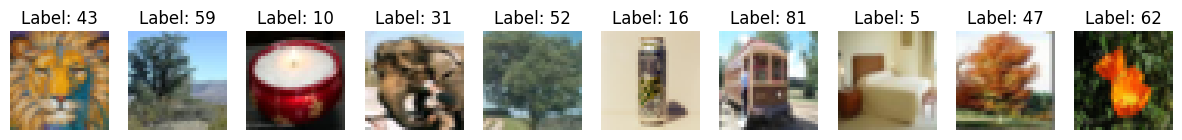

In [79]:
import matplotlib.pyplot as plt

def display_samples(dataset, num_samples=10):
    plt.figure(figsize=(15, 3))
    for i, (images, labels) in enumerate(dataset.take(1)):
        for j in range(num_samples):
            plt.subplot(1, num_samples, j+1)
            plt.imshow(images[j].numpy())
            plt.title(f"Label: {labels[j].numpy()}")
            plt.axis('off')
        break
    plt.show()

# Display samples from the training set
display_samples(dst, num_samples=10)


--- Sample Training Images ---


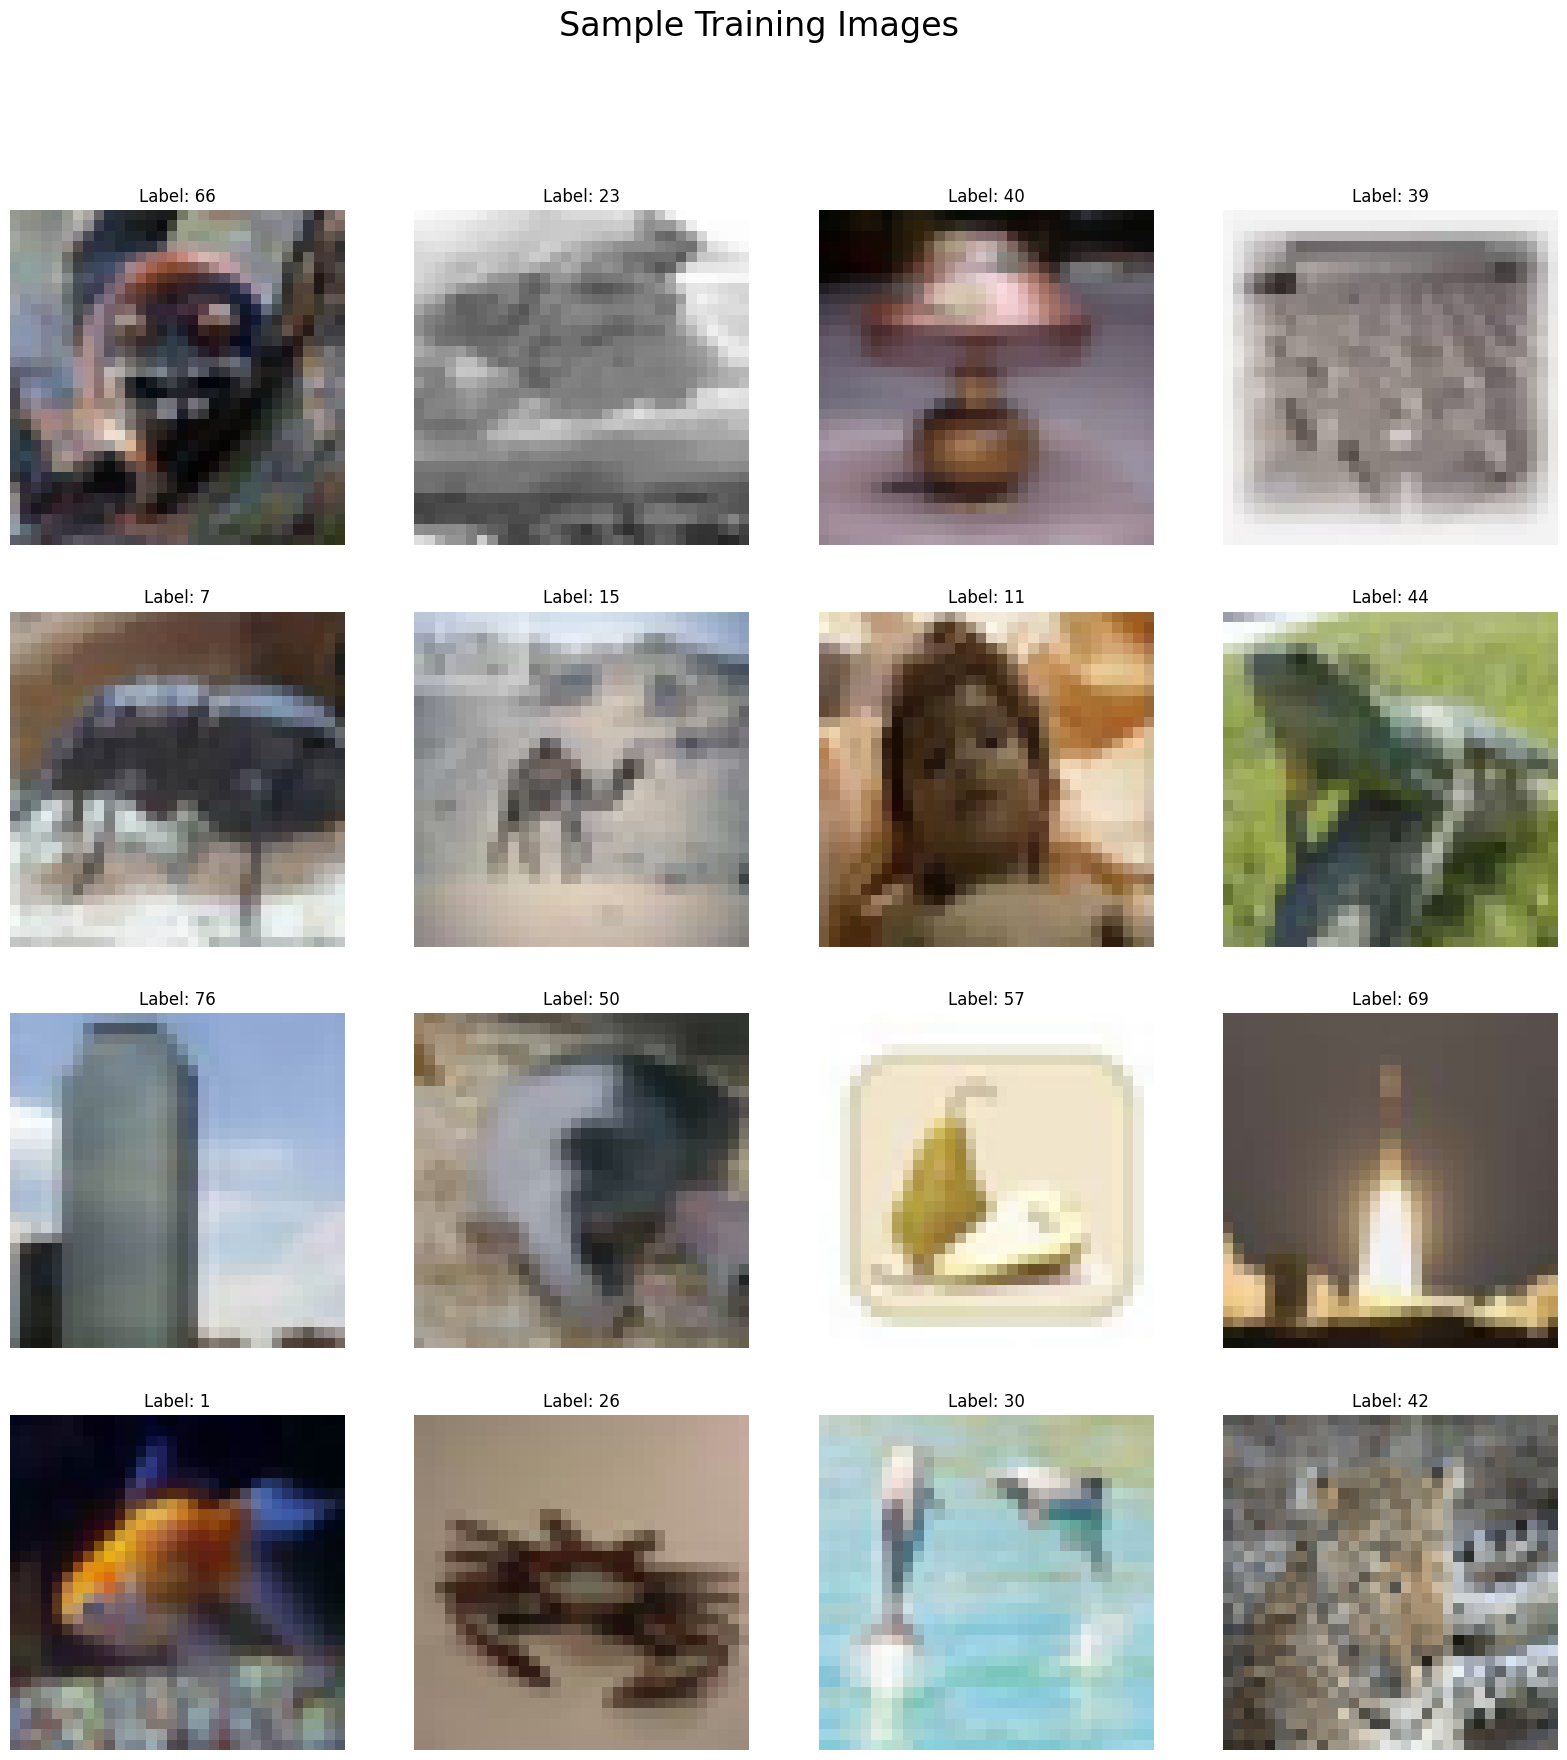


--- Sample Validation Images ---


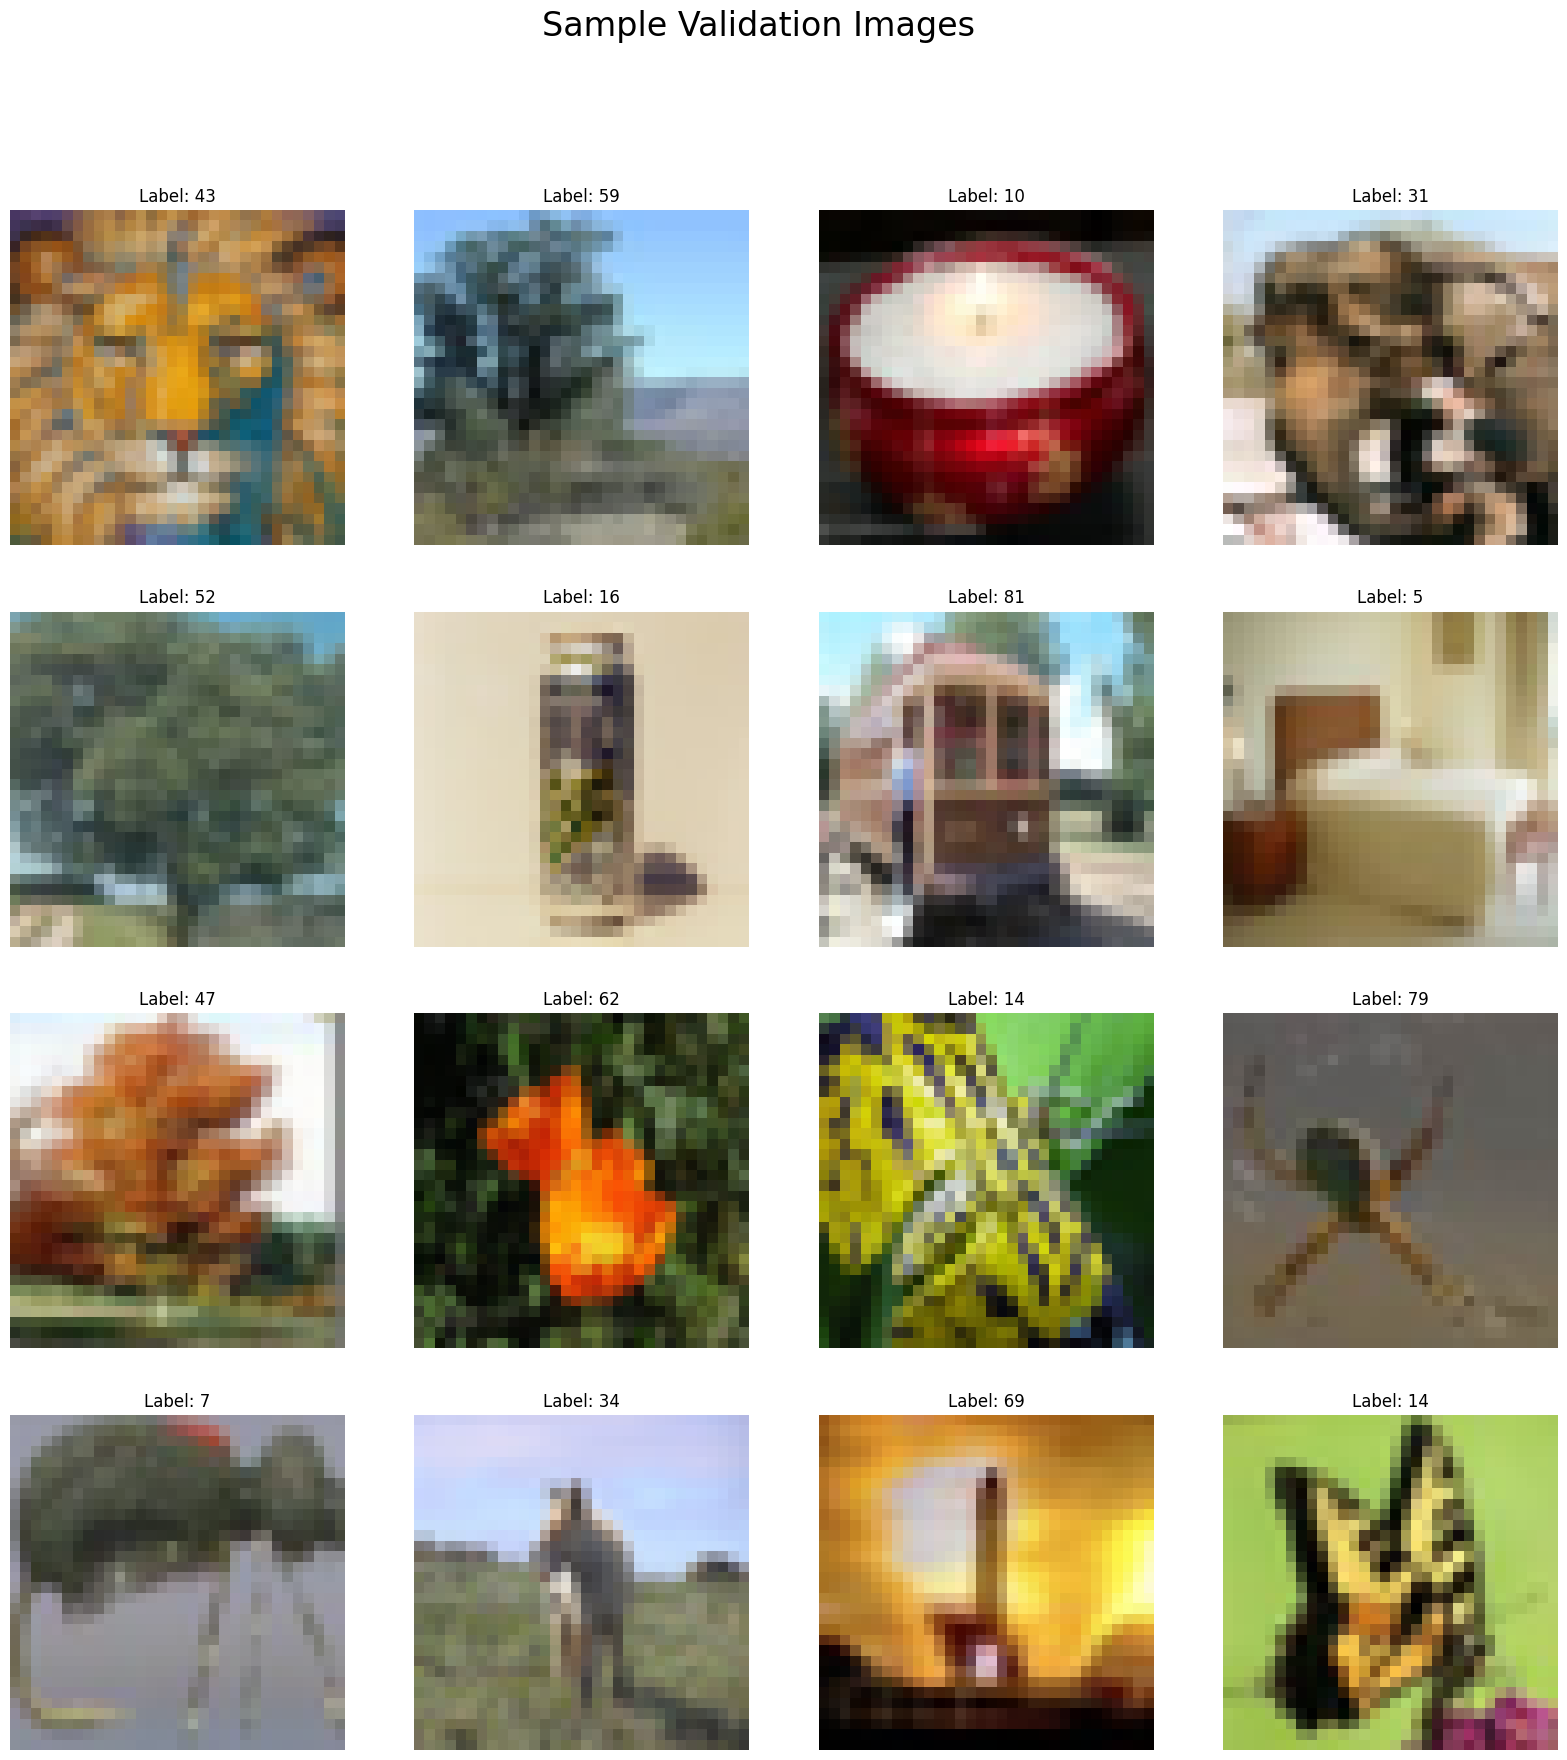

In [125]:
import matplotlib.pyplot as plt

def display_sample_images(dataset, num_batches=1, num_images=10, title='Sample Images'):
    """
    Displays a grid of sample images with their labels from the dataset.

    Args:
        dataset (tf.data.Dataset): The dataset to sample from.
        num_batches (int): Number of batches to sample.
        num_images (int): Number of images to display.
        title (str): Title of the plot.
    """
    images = []
    labels = []

    for batch_images, batch_labels in dataset.take(num_batches):
        images.extend(batch_images.numpy())
        labels.extend(batch_labels.numpy())
        if len(images) >= num_images:
            break

    images = images[:num_images]
    labels = labels[:num_images]

    # Determine grid size
    grid_size = int(np.ceil(np.sqrt(num_images)))

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=24)
    plt.show()

# Display sample images from Training Set
print("\n--- Sample Training Images ---")
display_sample_images(ds, num_batches=1, num_images=16, title='Sample Training Images')

# Display sample images from Validation Set
print("\n--- Sample Validation Images ---")
display_sample_images(dst, num_batches=1, num_images=16, title='Sample Validation Images')


In [10]:
# lets save our model
model.save("color_model_2.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


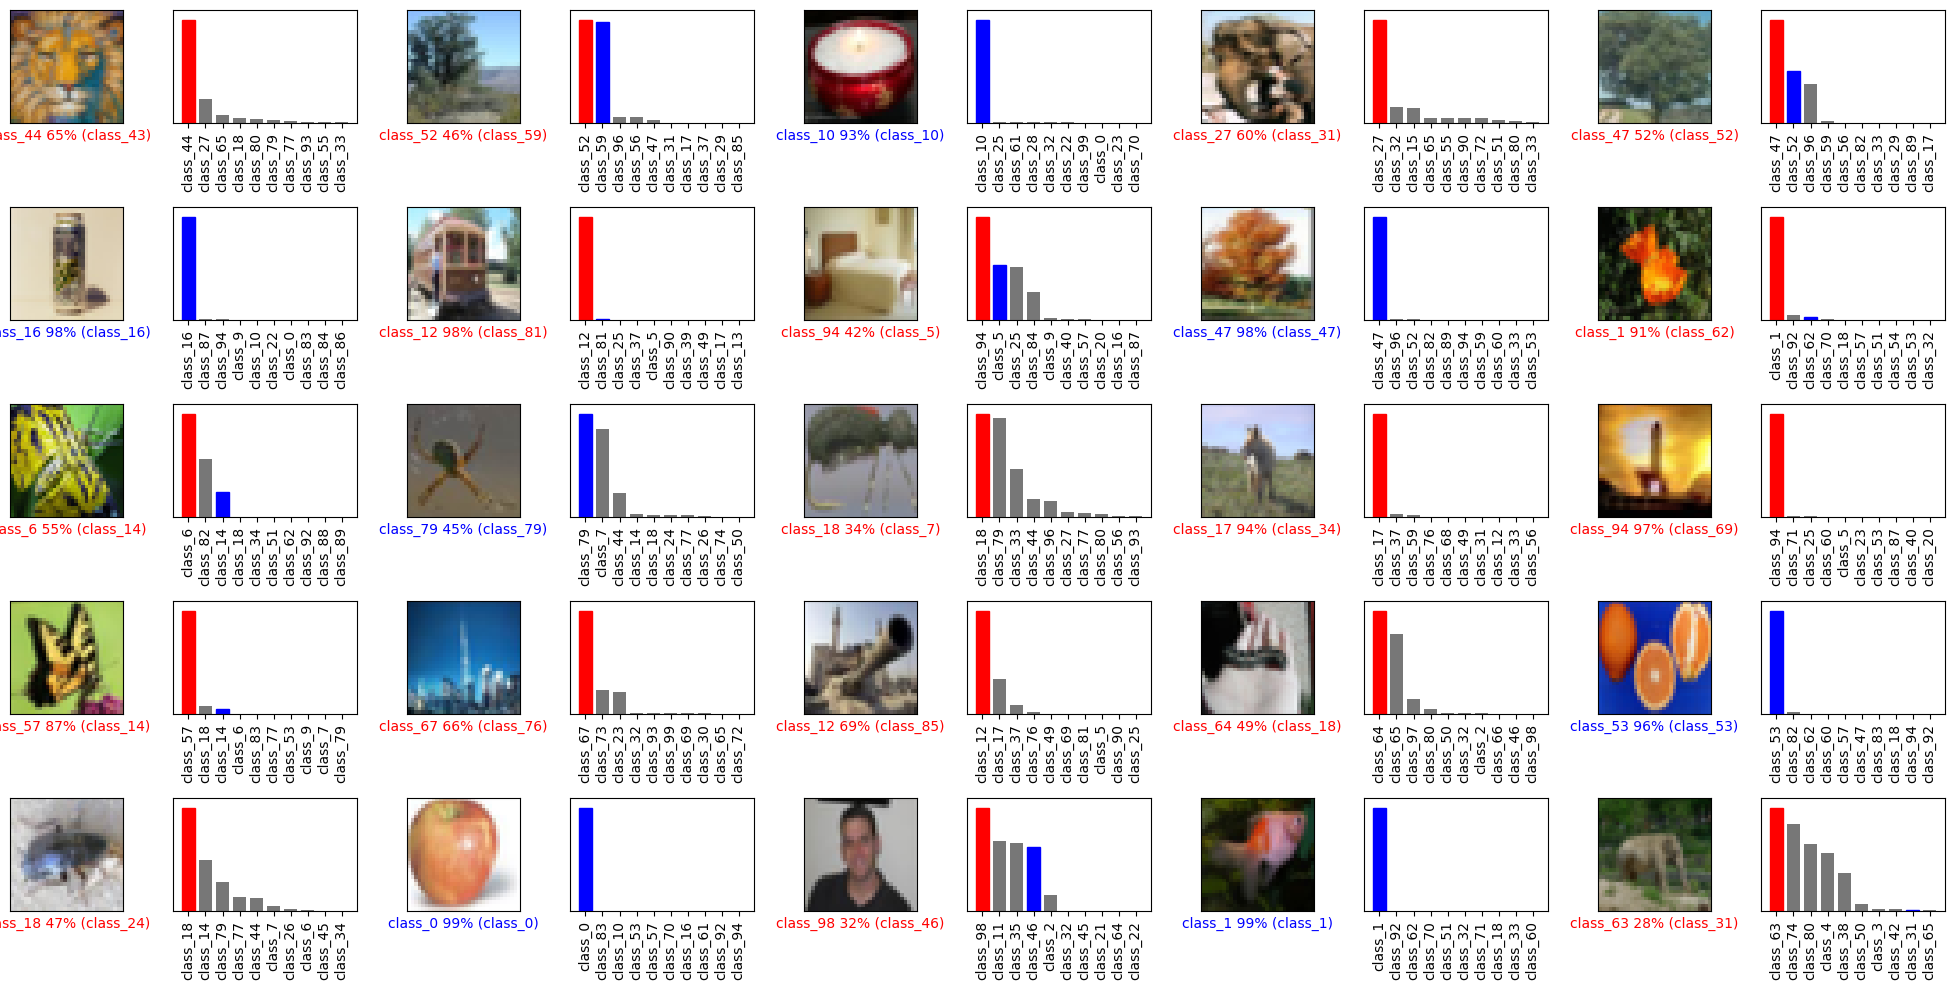

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# ----------------------------
# 1. Preparing the Probability Model
# ----------------------------

# Assuming 'model' is your trained Keras model with a softmax activation in the final layer
probability_model = model  # Remove the additional Softmax layer

# ----------------------------
# 2. Defining the Number of Images to Plot
# ----------------------------

num_rows = 5
num_cols = 5
num_images = num_rows * num_cols

# ----------------------------
# 3. Extracting Images and Labels from the Validation Dataset
# ----------------------------

valid_images = []
valid_labels = []

# Iterate over the validation dataset to collect 'num_images' samples
for image_batch, label_batch in dst.take((num_images // batch_size) + 1):
    # Convert tensors to numpy arrays
    images = image_batch.numpy()
    labels_batch = label_batch.numpy()

    # Check if labels are one-hot encoded
    if len(labels_batch.shape) > 1 and labels_batch.shape[1] > 1:
        # Convert one-hot vectors to integer indices
        labels_int = np.argmax(labels_batch, axis=1)
    else:
        # If labels are already integers
        labels_int = labels_batch.flatten()

    # Append images and labels to the lists
    for img, lbl in zip(images, labels_int):
        valid_images.append(img)
        valid_labels.append(lbl)
        if len(valid_images) == num_images:
            break
    if len(valid_images) == num_images:
        break

# Convert lists to numpy arrays for easier indexing
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

# ----------------------------
# 4. Running Predictions
# ----------------------------

# Run predictions on the collected images
predictions = probability_model.predict(valid_images)

# ----------------------------
# 5. Defining Class Names
# ----------------------------

# Define your class names here. Replace the dummy class names with your actual class names.
# Example for ImageNet with 1000 classes, you can load them from a file or another source.
# Here, we create dummy class names for demonstration purposes.
num_classes = predictions.shape[1]
class_names = [f'class_{i}' for i in range(num_classes)]  # Replace with actual class names

# ----------------------------
# 6. Defining the Plotting Functions
# ----------------------------

def plot_image(i, predictions_array, true_label, img):
    """
    Plots a single image with its predicted and true labels.

    Parameters:
    - i: Index of the image to plot.
    - predictions_array: Array of prediction probabilities for the image.
    - true_label: Array of true label indices.
    - img: Array of image data.
    """
    true_label = int(true_label[i])
    img = img[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Check if image has a single channel (grayscale) or multiple (RGB)
    if img.shape[-1] == 1:
        plt.imshow(img.squeeze(), cmap=plt.cm.binary)
    else:
        plt.imshow(img)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(
        class_names[predicted_label],
        100*np.max(predictions_array),
        class_names[true_label]),
        color=color)

def plot_top10_value_array(i, predictions_array, true_label):
    """
    Plots the top 10 prediction probabilities for a single image.

    Parameters:
    - i: Index of the image to plot.
    - predictions_array: Array of prediction probabilities for the image.
    - true_label: Array of true label indices.
    """
    true_label = int(true_label[i])
    plt.grid(False)
    plt.yticks([])
    plt.xticks(range(10))  # We'll display only top 10 classes

    # Get the top 10 predictions (indices and values)
    top10_indices = np.argsort(predictions_array)[::-1][:10]
    top10_values = predictions_array[top10_indices]

    # Dynamic y-limits based on top10 values
    min_val = top10_values.min()
    max_val = top10_values.max()
    # Add some padding so bars don't touch the edges exactly
    margin = (max_val - min_val) * 0.1 if max_val > min_val else 0.1
    plt.ylim([max(0, min_val - margin), max_val + margin])

    thisplot = plt.bar(range(10), top10_values, color="#777777")

    # Predicted label is the top-1 in this top-10 subset
    predicted_label = top10_indices[0]

    # Color the predicted label (top class)
    if predicted_label != true_label:
        # If incorrect prediction
        thisplot[0].set_color('red')
    else:
        # If correct prediction
        thisplot[0].set_color('blue')

    # If the true label is in the top 10, color it blue if not already colored
    if true_label in top10_indices:
        true_label_pos = np.where(top10_indices == true_label)[0][0]
        # Only color blue if it's not the predicted label
        if true_label != predicted_label:
            thisplot[true_label_pos].set_color('blue')

    # Set the x-axis labels to the class names for top 10
    plt.xticks(range(10), [class_names[idx] for idx in top10_indices], rotation=90)

# ----------------------------
# 7. Plotting the Images and Predictions
# ----------------------------

# Create a figure to hold the subplots
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    # Plot the image and its prediction
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], valid_labels, valid_images)

    # Plot the top 10 prediction probabilities
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_top10_value_array(i, predictions[i], valid_labels)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
